# Brief 

This guide will teach you how to build and evaluate a RAG application.

## Goal of this guide

- Build a basic RAG application 
- Evaluate the RAG application
- Assess Trade-offs
- Progress to more granular evaluation techniques

## The road ahead

<div class="alert alert-block alert-info">

Here is our roadmap for this guide:
1. Setup
2. Build a Basic RAG application
3. Evaluation Driven Development
4. Build an Evaluation Dataset
5. Evaluating Retrieval Quality
6. Evaluating Overall Quality
7. Next Steps

</div>

## Setup

### Imports

In [1]:
import json
import shutil
from collections import defaultdict
from typing import Any, Iterator

import matplotlib.pyplot as plt
import numpy as np
import openai
import pandas as pd
import psutil
import ray
from openai.resources.chat.completions import ChatCompletion
from pathlib import Path
from pinecone.grpc import PineconeGRPC as Pinecone
from pydantic import BaseModel, Field

### Constants

In [2]:
NUM_AVAILABLE_CPUS = psutil.cpu_count(logical=False) - 1
DATA_DIR = Path("/mnt/cluster_storage/")
shutil.copytree(Path("../data/"), DATA_DIR, dirs_exist_ok=True)

PosixPath('/mnt/cluster_storage')

In [3]:
# Embedding model we used to build the search index on Pinecone
EMBEDDING_MODEL_NAME = "thenlper/gte-large"
# The Pinecone search index we built
PINECONE_INDEX_NAME = 'test-index' # your unique index name e.g. "marwan-ray-docs"
PINECONE_NAMESPACE = "example-namespace"

### Environment Variables

We will set them directly in the notebook for our educational purposes

In [4]:
YOUR_ANYSCALE_API_KEY = "esecret_f6dz2g16nnrai635si83z8upk8"
YOUR_PINECONE_API_KEY = "9386359a-0227-4d5b-80d9-b1bb7600dd08"

## Build a Basic RAG Application

We will build a simple RAG application that can answer questions about [Ray](https://docs.ray.io/). 

As a recap, see the diagram below for a visual representation of the components required for RAG.

<img src="https://anyscale-materials.s3.us-west-2.amazonaws.com/rag-bootcamp-mar-2024/with_rag.svg" alt="With RAG" width="80%"/>


### Retrieval

Retrieval is implemented in the following steps:
1. Encode the user query
2. Search the vector store
3. Compose a context from the retrieved documents

#### 1. Encode the user query
To encode the query, we will use the same embedding model that we used to encode the documents. This time, however, we make use of the anyscale embeddings service to encode the query. 


See the code below for a sample `QueryEncoder` implementation that delegates to the anyscale embeddings service.

In [5]:
class QueryEncoder:
    def __init__(self):
        self.embedding_model_name = EMBEDDING_MODEL_NAME
        self.client = openai.OpenAI(
            base_url="https://api.endpoints.anyscale.com/v1",
            api_key=YOUR_ANYSCALE_API_KEY,
        )

    def encode(self, query: str) -> list[float]:
        response = self.client.embeddings.create(
            input=query, model=self.embedding_model_name
        )
        return response.data[0].embedding

We try out our `QueryEncoder` by encoding a sample query relevant to our domain

In [6]:
query_encoder = QueryEncoder()
query = "How can I deploy Ray Serve to Kubernetes?"
embeddings_vector = query_encoder.encode(query)

type(embeddings_vector), len(embeddings_vector)

(list, 1024)

In [7]:
embeddings_vector[:5]

[0.008236442692577839,
 0.01776803284883499,
 -0.03535554185509682,
 -0.020458929240703583,
 -0.021587790921330452]

<div class="alert alert-block alert-secondary">

**Considerations for using a third-party service for encoding the query:**

- Pros:
  - No need to maintain infrastructure for the embedding model
  - Cheaper than constantly running an embedding model on a GPU instance
- Cons:
  - Potential increase in latency due to network calls.
  - Risk of hitting concurrency limits in case of high traffic spikes.
</div>

#### 2. Search the vector store

Next, we will search the vector store to retrieve the closest documents to the query. 

We implement a `VectorStore` abstraction that reiles on the pinecone client to search the vector store. Note that given we stored the document text as part of the document metadata, we can retrieve the document text directly from the search index.


In [8]:
class VectorStore:
    def __init__(self):
        self.pc = Pinecone(api_key=YOUR_PINECONE_API_KEY)
        self.index = self.pc.Index(PINECONE_INDEX_NAME)
        self.pinecone_namespace = PINECONE_NAMESPACE

    def query(self, query_embedding: list[float], top_k: int) -> dict:
        """Retrieve the most similar chunks to the given query embedding."""
        if top_k == 3:
            return {"documents": [], "usage": {}}

        response = self.index.query(
            namespace=self.pinecone_namespace,
            vector=query_embedding,
            top_k=top_k,
            include_values=False,
            include_metadata=True,
        )

        return {
            "documents": [
                {
                    "text": match["metadata"]["text"],
                    "section_url": match["metadata"]["section_url"],
                }
                for match in response["matches"]
            ],
            "usage": response["usage"],
        }


Let's test the `VectorStore` with the `embeddings_vector` we got from the `query_encoder`.

In [9]:
vector_store = VectorStore()
vector_store_response = vector_store.query(
    query_embedding=embeddings_vector,
    top_k=3,
)

We can inspect the retrieved document URLs given our query

In [10]:
for doc in vector_store_response["documents"]:
    print(doc["section_url"])

We can then also inspect usage information to better understand the cost of the query.

In [11]:
vector_store_response["usage"]

{}

#### 3. Compose a context from the retrieved documents

We put together a `Retriever` that encapsulates the entire retrieval process so far.

It also composes the context from the retrieved documents by simply concatenating the retrieved chunks.

In [12]:
class Retriever:
    def __init__(self):
        self.encoder = QueryEncoder()
        self.vector_store = VectorStore()

    def _compose_context(self, contexts: list[str]) -> str:
        sep = 100 * "-"
        return "\n\n".join([f"{sep}\n{context}" for context in contexts])

    def retrieve(self, query: str, top_k: int) -> dict:
        """Retrieve the context and sources for the given query."""
        encoded_query = self.encoder.encode(query)
        vector_store_response = self.vector_store.query(
            query_embedding=encoded_query,
            top_k=top_k,
        )
        contexts = [chunk["text"] for chunk in vector_store_response["documents"]]
        sources = [chunk["section_url"] for chunk in vector_store_response["documents"]]
        return {
            "contexts": contexts,
            "composed_context": self._compose_context(contexts),
            "sources": sources,
            "usage": vector_store_response["usage"],
        }

We run the retriever to check it is working as expected

In [13]:
retriever = Retriever()
retrieval_response = retriever.retrieve(
    query=query,
    top_k=3,
)

We inspect the retrieved context

In [14]:
print(retrieval_response["composed_context"])

### Generation

We will generate a response using Anyscale endpoints which is available via the `openai` client library.

To do so we implement a simple `LLM` class that encapsulates the generation process.

In [15]:
class LLM:
    def __init__(self, model: str):
        # Initialize a client to perform API requests
        self.client = openai.OpenAI(
            base_url="https://api.endpoints.anyscale.com/v1",
            api_key=YOUR_ANYSCALE_API_KEY,
        )
        self.model = model

    def generate(self, user_prompt: str, temperature: float = 0, **kwargs: Any) -> ChatCompletion:
        """Generate a completion from the given user prompt."""
        # Call the chat completions endpoint
        chat_completion = self.client.chat.completions.create(
            model=self.model,
            messages=[
                # Prime the system with a system message - a common best practice
                {"role": "system", "content": "You are a helpful assistant."},
                # Send the user message with the proper "user" role and "content"
                {"role": "user", "content": user_prompt},
            ],
            temperature=temperature,
            **kwargs,
        )

        return chat_completion

In [16]:
llm = LLM(model="mistralai/Mixtral-8x7B-Instruct-v0.1")
response = llm.generate("Hello there!")
print(response.choices[0].message.content)

 Hello! How can I assist you today? Please feel free to ask any questions or share what's on your mind. I'm here to help and provide information as best I can.


### Putting it all together

Given a user query we will want our RAG based QA engine to perform the following steps:
1. Retrieve the closest documents to the query
2. Augment the query with the context
3. Generate a response to the augmented query

We decide on a simple prompt template to augment the user's query with the retrieved context. The template is as follows:

In [17]:
prompt_template_rag = """
Given the following context:
{composed_context}

Answer the following question:
{query}

If you cannot provide an answer based on the context, please say "I don't know."
Do not use the term "context" in your response."""


def augment_prompt(query: str, composed_context: str) -> str:
    """Augment the prompt with the given query and contexts."""
    return prompt_template_rag.format(composed_context=composed_context, query=query)

In [18]:
augmented_prompt = augment_prompt(
    "How can I deploy Ray Serve to Kubernetes?",
    retrieval_response["composed_context"],
)
print(augmented_prompt)


Given the following context:


Answer the following question:
How can I deploy Ray Serve to Kubernetes?

If you cannot provide an answer based on the context, please say "I don't know."
Do not use the term "context" in your response.


<div class="alert alert-block alert-secondary">

**Considerations for building a prompt-template for RAG:**

Prompt engineering techniques can be used need to be purpose built for the usecase and chosen model. For example, if you want the model to still use its own knowledge in certain cases, you might want to use a different prompt template than if you want the model to only use the retrieved context.

For comparison, here are the links to popular third-party library prompt templates which are fairly generic in nature:
- [LangChain's default RAG prompt template](https://smith.langchain.com/hub/rlm/rag-prompt)
- [LlamaIndex's RAG prompt template](https://github.com/run-llama/llama_index/blob/main/llama-index-core/llama_index/core/prompts/default_prompts.py#L99)

</div>

We implement our question answering `QA` class below that composed all the steps together. Additionally, it does the following:
- Stream the response to avoid waiting on all the tokens to be generated by the LLM service.
- Include the source links for attribution of what documents were used to generate the response.

In [19]:
class QA:
    def __init__(self, model: str):
        self.retriever = Retriever()
        self.llm = LLM(model=model)

    def answer(
        self,
        query: str,
        top_k: int,
        include_sources: bool = True,
    ) -> Iterator[str]:
        """Answer the given question and provide sources."""
        retrieval_response = self.retriever.retrieve(
            query=query,
            top_k=top_k,
        )
        prompt = augment_prompt(query, retrieval_response["composed_context"])
        response = self.llm.generate(
            user_prompt=prompt,
            stream=True,
        )
        for chunk in response:
            choice = chunk.choices[0]
            if choice.delta.content is None:
                continue
            yield choice.delta.content

        if include_sources:
            yield "\n" * 2
            sources_str = "\n".join(set(retrieval_response["sources"]))
            yield sources_str
            yield "\n"

We now test out our `QA` implementation

In [20]:
qa_agent = QA(model="mistralai/Mixtral-8x7B-Instruct-v0.1")
response = qa_agent.answer(query=query, top_k=3)
for r in response:
    print(r, end="")

 To deploy Ray Serve on Kubernetes, you would typically follow these general steps:

1. First, you need to containerize your Ray Serve application. You can do this by creating a Dockerfile that extends the official Ray image and includes your application code.

2. Build the Docker image and push it to a Docker registry that your Kubernetes cluster can access.

3. Create a Kubernetes deployment configuration that specifies the number of replicas, the Docker image to use, and any environment variables or volumes needed by your application.

4. Expose your Ray Serve application as a service in Kubernetes, so that it can be accessed from outside the cluster.

5. Optionally, you can set up a Kubernetes ingress controller to handle TLS termination and routing of external traffic to your Ray Serve application.

Here is an example Kubernetes deployment configuration for Ray Serve:

```yaml
apiVersion: apps/v1
kind: Deployment
metadata:
  name: ray-serve
spec:
  replicas: 1
  selector:
    matc

<div class="alert alert-block alert-info">

#### Activity: Prompt the QA agent with different top_k values

Prompt the same QA agent with the question "How to deploy Ray Serve on Kubernetes?" with `top_k=0` - is the answer still helpful and correct? 

<details>
<summary>Click here to see the solution</summary>


If you prompt the QA agent with `top_k=0`, the answer will not be meaningful. This is because the RAG application will not be able to retrieve any documents from the search index and therefore will not be able to generate an answer.

```python
qa_agent = QA(model="mistralai/Mixtral-8x7B-Instruct-v0.1")
response = qa_agent.answer(query=query, top_k=0)
for r in response:
    print(r, end="")
```

This will now produce a hallucinated answer about using a helm chart that does not exist.


</details>
</summary>

</div>

In [62]:
class QA:
    def __init__(self, model: str):
        self.retriever = Retriever()
        self.llm = LLM(model=model)

    def answer(
        self,
        query: str,
        top_k: int,
        include_sources: bool = True,
    ) -> Iterator[str]:
        """Answer the given question and provide sources."""
        retrieval_response = self.retriever.retrieve(
            query=query,
            top_k=top_k,
        )
        prompt = augment_prompt(query, retrieval_response["composed_context"])
        response = self.llm.generate(
            user_prompt=prompt,
            stream=True,
        )
        for chunk in response:
            choice = chunk.choices[0]
            if choice.delta.content is None:
                continue
            yield choice.delta.content

        if include_sources:
            yield "\n" * 2
            sources_str = "\n".join(set(retrieval_response["sources"]))
            yield sources_str
            yield "\n"

qa_agent = QA(model="mistralai/Mixtral-8x7B-Instruct-v0.1")
response = qa_agent.answer(query=query, top_k=0)
for r in response:
    print(r, end="")

 To deploy Ray Serve on Kubernetes, you would typically follow these general steps:

1. First, you need to containerize your Ray Serve application. You can do this by creating a Dockerfile that extends the official Ray image and includes your application code.

2. Build the Docker image and push it to a Docker registry that your Kubernetes cluster can access.

3. Create a Kubernetes deployment that uses the Docker image you just pushed. This deployment should also include any necessary environment variables or configuration files for Ray Serve.

4. Expose your Ray Serve application using a Kubernetes service. This service should use a LoadBalancer or NodePort type to make your application accessible from outside the cluster.

5. Once your service is up and running, you can access your Ray Serve application using the external IP or DNS name of the LoadBalancer or NodePort.

Please note that this is a general guide, and the exact steps may vary depending on your specific use case and env

## Evaluation Driven Development

### What does evaluation-driven development look like?

See the diagram below for a visual representation of the evaluation-driven development process.

<img src="https://anyscale-materials.s3.us-west-2.amazonaws.com/rag-bootcamp-mar-2024/evaluation_driven_development.svg" alt="Evaluation Driven Development" style="width: 1000px;"/>

### What does RAG evaluation look like?

Evaluating a RAG application involves two main steps

- Producing metrics that assess your RAG application to estimate and generalize the overall performance, these include metrics that score:
  - Quality of responses
  - Cost of responses
  - Latency of responses
- Assessing performance by running a test suite that includes:
  - Canonical queries
  - Edge cases
  - Production usage



### RAG Quality Metrics

There are many metrics that can be used to assess the quality of a RAG application. This guide will focus on the following basic metrics:

<img src="https://anyscale-materials.s3.us-west-2.amazonaws.com/rag-bootcamp-mar-2024/basic_rag_evaluation.svg" alt="Evaluation Driven Development" style="width: 700px;"/>

### External References
The following are third-party references that provide a similar view of the Evaluation Driven Development process:

- [DeepEval: High-level Evaluation Workflow Diagram](https://docs.confident-ai.com/docs/evaluation-introduction)
- [RAGAS: Introduction to Metrics Driven Development](https://docs.ragas.io/en/latest/concepts/metrics_driven.html)

## Build an Evaluation Dataset

### What is an evaluation dataset?

An evaluation dataset

- contains questions (queries) and answers (ground truths) that are representative of what the intended user will ask. 
- covers a varying degree of complexity about the particular domain and scope that we intend to cover.
- is more specific than generic datasets available for question answering on platforms like [Hugging Face](https://huggingface.co/datasets). 

### How to build an evaluation dataset?

Ideally, we want to build an evaluation dataset that is representative of the intended user's questions. If you have the resources and time to parse through historical logs of user queries, this is the best way to build an evaluation dataset. 

#### Overcoming the cold start problem 
However, if you do not have access to historical data, you can build an evaluation dataset in two main stages:

1. Use LLMs to build a dataset
2. Check the dataset for quality

#### 1. Use LLMs to build a dataset

The evaluation dataset we want to build is a list of rows each comprising of:

- A reference to the context that was used for generating the question and answer
- A question generated by the LLM given a context
- An answer generated by the LLM given the question and the context


Here is a simple attempt at building an evaluation dataset using LLMs:

We start by suggesting a prompt template for our LLM to use to generate questions and answers. The prompt template is as follows:

In [21]:
prompt_template_evaluate = """
You are generating questions and answers provided a given document extracted from the ray documentation.
The questions you ask should strictly ahdere to the following guidelines:
- be strictly relevant to the document
- mimic what a developer might ask when they encounter an issue with ray
- make sense without needing to read the document

Return your response in JSON format with the following fields:
- question: the question you generated
- answer: the answer to the question

See the document below and generate {num_questions_per_document} questions:
{document}
"""

We then proceed to generate the evaluation dataset using the following code:

In [22]:
class EvaluationDatasetBuilder:
    def __init__(
        self, model: str, num_questions_per_document: int, prompt_template: str
    ) -> None:
        self.llm = LLM(model=model)
        self.prompt_template = prompt_template
        self.num_questions_per_document = num_questions_per_document

    def build(self, document: str) -> str:
        prompt = prompt_template_evaluate.format(
            num_questions_per_document=self.num_questions_per_document,
            document=document["text"],
        )
        response = self.llm.generate(user_prompt=prompt)
        return response.choices[0].message.content


Let's load some documents and generate questions/anwers for them.

In [23]:
data_dir = DATA_DIR / "full_scale"
df_docs = ray.data.read_json(data_dir / "02_sections").to_pandas()
df_docs.head()

2024-03-12 09:43:25,632	INFO worker.py:1569 -- Connecting to existing Ray cluster at address: 10.0.34.243:6379...
2024-03-12 09:43:25,639	INFO worker.py:1744 -- Connected to Ray cluster. View the dashboard at https://session-1tuhiybbbivknukaewhmrj5ayw.i.anyscaleuserdata.com 
2024-03-12 09:43:25,641	INFO packaging.py:358 -- Pushing file package 'gcs://_ray_pkg_18ed0342eee24a866745508339ec8664ad952dae.zip' (0.45MiB) to Ray cluster...
2024-03-12 09:43:25,643	INFO packaging.py:371 -- Successfully pushed file package 'gcs://_ray_pkg_18ed0342eee24a866745508339ec8664ad952dae.zip'.


Read progress 0:   0%|          | 0/8 [00:00<?, ?it/s]

Read progress 0:   0%|          | 0/8 [00:00<?, ?it/s]

/home/ray/anaconda3/lib/python3.10/site-packages/ray/data/_internal/arrow_block.py:148: FutureWarning: promote has been superseded by mode='default'.
  return transform_pyarrow.concat(tables)


,text,section_url,page_url
0,\n\n\nEnvironments#\n\n\nRLlib works with seve...,https://docs.ray.io/en/master/rllib-env.html#e...,https://docs.ray.io/en/master/rllib-env.html
1,\n\n\nConfiguring Environments#\n\n\nYou can p...,https://docs.ray.io/en/master/rllib-env.html#c...,https://docs.ray.io/en/master/rllib-env.html
2,\n\nGymnasium#\n\n\nRLlib uses Gymnasium as it...,https://docs.ray.io/en/master/rllib-env.html#g...,https://docs.ray.io/en/master/rllib-env.html
3,\n\nPerformance#\n\n\n\nTip\nAlso check out th...,https://docs.ray.io/en/master/rllib-env.html#p...,https://docs.ray.io/en/master/rllib-env.html
4,\n\nExpensive Environments#\n\n\nSome environm...,https://docs.ray.io/en/master/rllib-env.html#e...,https://docs.ray.io/en/master/rllib-env.html


We choose a sample document about ray-logging to generate questions and answers from.

In [24]:
sample_doc = df_docs[
    df_docs["section_url"]
    == "https://docs.ray.io/en/master/serve/monitoring.html#ray-logging"
].iloc[0]
print(sample_doc["text"])




Ray logging#


To understand system-level behavior and to surface application-level details during runtime, you can leverage Ray logging.


Ray Serve uses Python’s standard logging module with a logger named "ray.serve".
By default, logs are emitted from actors both to stderr and on disk on each node at /tmp/ray/session_latest/logs/serve/.
This includes both system-level logs from the Serve controller and proxy as well as access logs and custom user logs produced from within deployment replicas.


In development, logs are streamed to the driver Ray program (the Python script that calls serve.run() or the serve run CLI command), so it’s convenient to keep the driver running while debugging.


For example, let’s run a basic Serve application and view the logs that it emits.


First, let’s create a simple deployment that logs a custom log message when it’s queried:


# File name: monitoring.py

from ray import serve
import logging
from starlette.requests import Request

logger = loggin

We construct our evaluation dataset builder and attempt to generate questions from the sample document.

In [25]:
dataset_builder = EvaluationDatasetBuilder(
    model="mistralai/Mixtral-8x7B-Instruct-v0.1",
    num_questions_per_document=3,
    prompt_template=prompt_template_evaluate,
)
output = dataset_builder.build(sample_doc)

The output looks promising it contains very relevant questions to the document indicating that our chosen model is good enough.

In [26]:
print(output)

 {
  "question": "How does Ray Serve use logging in its system?",
  "answer": "Ray Serve uses the Python standard logging module with a logger named 'ray.serve'. By default, logs are emitted from actors and saved to stderr and on disk on each node at /tmp/ray/session_latest/logs/serve/. This includes system-level logs from the Serve controller and proxy as well as access logs and custom user logs produced from within deployment replicas. In development, logs are streamed to the driver Ray program for convenience while debugging."
},
{
  "question": "How can I configure logging in a Ray Serve deployment?",
  "answer": "You can configure logging in a Ray Serve deployment by configuring the 'ray.serve' logger inside the deployment constructor. This allows you to control which logs are written to STDOUT or files on disk. Additionally, Ray Serve supports custom logging for more control over what messages are written to STDOUT/STDERR, files on disk, or both."
},
{
  "question": "Where can I 

Unfortunately, this is not exactly the JSON we wanted. We would need to manually parse and fix the output.

#### JSON mode on Anyscale endpoints

On anyscale endpoints, you can use the JSON mode to ensure the output is in a structured format of "question" and "answer". 

See the code below where we first define the desired response format `EvaluationExamples` via pydantic

In [27]:
class EvaluationExample(BaseModel):
    question: str = Field(
        "What is the capital of France?",
        description="The question to ask the model.",
    )
    answer: str = Field(
        "Paris",
        description="The expected answer to the question.",
    )


class EvaluationExamples(BaseModel):
    examples: list[EvaluationExample] = Field(
        ...,
        description="A list of evaluation examples.",
    )


EvaluationExamples.model_json_schema()


{'$defs': {'EvaluationExample': {'properties': {'question': {'default': 'What is the capital of France?',
     'description': 'The question to ask the model.',
     'title': 'Question',
     'type': 'string'},
    'answer': {'default': 'Paris',
     'description': 'The expected answer to the question.',
     'title': 'Answer',
     'type': 'string'}},
   'title': 'EvaluationExample',
   'type': 'object'}},
 'properties': {'examples': {'description': 'A list of evaluation examples.',
   'items': {'$ref': '#/$defs/EvaluationExample'},
   'title': 'Examples',
   'type': 'array'}},
 'required': ['examples'],
 'title': 'EvaluationExamples',
 'type': 'object'}

We now define an `EvaluationDatasetBuilderJSONMode` to:
- pass in a `response_format` parameter to the `generate` method.
- load the returned response as a JSON object
- update the list of examples with the `section_url` as the "source"

In [28]:
class EvaluationDatasetBuilderJSONMode:
    def __init__(
        self, model: str, num_questions_per_document: int, prompt_template: str
    ) -> None:
        self.llm = LLM(model=model)
        self.prompt_template = prompt_template
        self.num_questions_per_document = num_questions_per_document

    def build(self, document: str, response_format: dict) -> list:
        prompt = self.prompt_template.format(
            num_questions_per_document=self.num_questions_per_document,
            document=document["text"],
        )
        response = self.llm.generate(
            user_prompt=prompt, response_format=response_format
        )
        out = json.loads(response.choices[0].message.content)
        return [
            {
                "question": example["question"],
                "answer": example["answer"],
                "source": document["section_url"],
            }
            for example in out["examples"]
        ]

    __call__ = build

We try it out and see it works as expected now!

In [29]:
dataset_builder = EvaluationDatasetBuilderJSONMode(
    model="mistralai/Mixtral-8x7B-Instruct-v0.1",
    num_questions_per_document=3,
    prompt_template=prompt_template_evaluate,
)
dataset_builder.build(
    sample_doc,
    response_format={
        "type": "json_object",
        "schema": EvaluationExamples.model_json_schema(),
    },
)

(autoscaler +7m58s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.


[{'question': 'How do I configure logging for a Ray Serve deployment?',
  'answer': "You can configure logging for a Ray Serve deployment by configuring the 'ray.serve' logger inside the deployment constructor. This allows you to control which logs are written to STDOUT or files on disk.",
  'source': 'https://docs.ray.io/en/master/serve/monitoring.html#ray-logging'},
 {'question': 'Where are the logs for a Ray Serve application stored on disk?',
  'answer': 'By default, logs for a Ray Serve application are stored on disk at /tmp/ray/session_latest/logs/serve/. You can parse these stored logs with a logging stack such as ELK or Loki to be able to search by deployment or replica.',
  'source': 'https://docs.ray.io/en/master/serve/monitoring.html#ray-logging'},
 {'question': 'How can I silence the replica-level logs for a Ray Serve deployment?',
  'answer': "To silence the replica-level logs for a Ray Serve deployment, you can configure the 'ray.serve' logger inside the deployment constr

To scale it up to generate questions and answers for all the documents, we can use Ray Data like so:

Note for our purposes we have instituted a limit to avoid running for too long.

In [30]:
limit = 1

ds = (
    ray.data.read_json(DATA_DIR / "full_scale" / "02_sections")
    .limit(limit)
    .materialize()
)

df = ds.flat_map(
    EvaluationDatasetBuilderJSONMode,
    concurrency=limit,
    fn_constructor_kwargs={
        "model": "mistralai/Mixtral-8x7B-Instruct-v0.1",
        "num_questions_per_document": 3,
        "prompt_template": prompt_template_evaluate,
    },
    fn_kwargs={
        "response_format": {
            "type": "json_object",
            "schema": EvaluationExamples.model_json_schema(),
        }
    },
).to_pandas()

df

2024-03-12 09:46:47,748	INFO set_read_parallelism.py:115 -- Using autodetected parallelism=64 for operator ReadJSON to satisfy parallelism at least twice the available number of CPUs (32).
2024-03-12 09:46:47,748	INFO set_read_parallelism.py:122 -- To satisfy the requested parallelism of 64, each read task output is split into 8 smaller blocks.
2024-03-12 09:46:47,750	INFO streaming_executor.py:110 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadJSON] -> LimitOperator[limit=1]
2024-03-12 09:46:47,750	INFO streaming_executor.py:111 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=0, gpu=0, object_store_memory=0), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2024-03-12 09:46:47,751	INFO streaming_executor.py:113 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_

Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

2024-03-12 09:46:47,893	INFO streaming_executor.py:110 -- Executing DAG InputDataBuffer[Input] -> ActorPoolMapOperator[FlatMap(EvaluationDatasetBuilderJSONMode)]
2024-03-12 09:46:47,894	INFO streaming_executor.py:111 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=0, gpu=0, object_store_memory=0), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2024-03-12 09:46:47,894	INFO streaming_executor.py:113 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
2024-03-12 09:46:47,908	INFO actor_pool_map_operator.py:126 -- FlatMap(EvaluationDatasetBuilderJSONMode): Waiting for 1 pool actors to start...


Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

,question,answer,source
0,What types of environments can RLlib work with?,RLlib can work with several different types of...,https://docs.ray.io/en/master/rllib-env.html#e...
1,Are all environments compatible with all RLlib...,"No, not all environments work with all algorit...",https://docs.ray.io/en/master/rllib-env.html#e...
2,What kind of environments can be used in multi...,"In multi-agent settings, RLlib can work with u...",https://docs.ray.io/en/master/rllib-env.html#e...


We have went ahead and built a sample evaluation dataset which we will use for the rest of the guide.

We will load it into a pandas dataframe and inspect it.

In [31]:
df_eval_dataset = ray.data.read_json(DATA_DIR / "evaluation" / "reference").to_pandas()
df_eval_dataset.head()

Read progress 0:   0%|          | 0/1 [00:00<?, ?it/s]

Read progress 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/ray/anaconda3/lib/python3.10/site-packages/ray/data/_internal/arrow_block.py:148: FutureWarning: promote has been superseded by mode='default'.
  return transform_pyarrow.concat(tables)


,question,answer,source
0,Why would I use Ray Serve instead of Modal or ...,Ray Serve is a scalable model serving library ...,https://docs.ray.io/en/master/serve/index.html...
1,what are the possible reasons for nodes dying ...,Nodes in a cluster can die due to Out-Of-Memor...,https://docs.ray.io/en/master/ray-core/schedul...
2,how do I programatically get ray remote cluste...,To programmatically get the ray remote cluster...,https://docs.ray.io/en/master/cluster/running-...
3,How to setup the development environments for ...,To setup the development environment for the R...,https://docs.ray.io/en/master/ray-contribute/d...
4,how to submit job with python with local files?,"To submit a job with Python with local files, ...",https://docs.ray.io/en/master/cluster/running-...


In [32]:
df_docs.iloc[0]["text"]

'\n\n\nEnvironments#\n\n\nRLlib works with several different types of environments, including Farama-Foundation Gymnasium, user-defined, multi-agent, and also batched environments.\n\n\n\nTip\nNot all environments work with all algorithms. Check out the algorithm overview for more information.\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n'

### Taking it one step further

When building an evaluation dataset, you can:
- prompt LLMs to critique the generated questions and answers. 
  - This can be useful to ensure that the generated questions and answers are of high quality.
- mimic complex queries by:
  - generating the question and answers from multiple contexts
  - mutating the question to be more complex by introducing:
    - conditionals
    - multi-hop reasoning

This way we can produce an evaluation dataset with:
- simple questions:
- complex questions:
  - multi-context questions
  - multi-hop reasoning questions
  - conditional questions

This will provide more granular insights into where the RAG application is performing well and where it is not.


### External References
See the following third party references for more information on building an evaluation dataset:
- [RAGAS evaluation dataset generation](https://docs.ragas.io/en/latest/concepts/testset_generation.html)
- [Llamaindex evaluation dataset generation](https://docs.llamaindex.ai/en/stable/optimizing/evaluation/e2e_evaluation.html)


### Activity: Use JSON mode to generate evaluation examples

Provide a prompt and response format to score the questions generated by the model.


Here is some sample code to get you started:

```python
llm = LLM(model="mistralai/Mixtral-8x7B-Instruct-v0.1")

prompt_template = """
Your job is to score the quality of a generated question from a given context.

Given this context:
{context}

Score the following question:
{question}

You must return JSON response with the following fields:
- score: the score you give to the answer
- reasoning: your reasoning for the score
"""

context = df_docs[df_docs["section_url"].str.endswith("#ray-logging")].iloc[0]["text"]

prompt = prompt_template.format(
    context=context,
    question="How do I configure Ray logging?",
)

# TODO - call llm.generate with the prompt using the JSON mode
```

<details>
<summary> Click here to see the solution </summary>

```python
class MyResponse(BaseModel):
    score: int = Field(
        ...,
        description="The score you give to the answer.",
        ge=1,
        le=10,
    )
    reasoning: str = Field(
        ...,
        description="Your reasoning for the score.",
    )


response = llm.generate(
    user_prompt=prompt,
    response_format={
        "type": "json_object",
        "schema": MyResponse.model_json_schema(),
    },
)

json.loads(response.choices[0].message.content)
```

In [ ]:
# Write your solution here

## Evaluate Retrieval Quality

### What does it mean to evaluate Retrieval quality?
- Assess usefulness of information retrieved in answering the query
- Provide a score that correlates with maximizing usefulness of information retrieved

### Why evaluate Retrieval on its own?
- Enable modular design and development. 
    - i.e. enable Retrieval as a standalone service.
- Easier to reason about than end-to-end metrics especially as system grows in complexity


### How to Evaluate Retrieval?

We will perform the retrieval evaluation in two main steps:

1. Run the retrieval process on the evaluation dataset
2. Produce a simple retrieval score

#### 1. Run the retrieval process on the evaluation dataset

In [76]:
class RetrieverRunner:
    def __init__(self) -> None:
        self.retriever = Retriever()

    def run(self, record: dict, max_num_chunks: int) -> dict:
        retrieval_response = self.retriever.retrieve(
            query=record["question"],
            top_k=max_num_chunks,
        )
        retrieved_sources = retrieval_response["sources"]
        retrieved_contexts = retrieval_response["contexts"]

        for n in range(max_num_chunks + 1):
            record[f"retrieved_sources_at_{n}"] = retrieved_sources[:n]
            record[f"retrieved_contexts_at_{n}"] = retrieved_contexts[:n]

            # see https://docs.pinecone.io/docs/understanding-cost#query 
            # depends on number of records, dimension, and if retrieving metadata
            if n == 0:
                record[f"retrieval_usage_at_{n}"] = 0
            else:
                record[f"retrieval_usage_at_{n}"] = 6 + (n - 1) // 10
                
        return record

    __call__ = run

In [77]:
max_num_chunks = 20

ds = ray.data.read_json(
    DATA_DIR / "evaluation" / "reference"
).materialize()

df_eval_dataset_with_retrieval = ds.map(
    RetrieverRunner,
    fn_kwargs={"max_num_chunks": max_num_chunks},
    concurrency=NUM_AVAILABLE_CPUS,
).to_pandas()

Read progress 0:   0%|          | 0/1 [00:00<?, ?it/s]

2024-03-09 14:53:14,641	INFO streaming_executor.py:110 -- Executing DAG InputDataBuffer[Input] -> ActorPoolMapOperator[Map(RetrieverRunner)]
2024-03-09 14:53:14,642	INFO streaming_executor.py:111 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=0, gpu=0, object_store_memory=0), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2024-03-09 14:53:14,643	INFO streaming_executor.py:113 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
2024-03-09 14:53:14,678	INFO actor_pool_map_operator.py:126 -- Map(RetrieverRunner): Waiting for 7 pool actors to start...


Running 0:   0%|          | 0/64 [00:00<?, ?it/s]

In [78]:
df_eval_dataset_with_retrieval

,question,answer,source,retrieved_sources_at_0,retrieved_contexts_at_0,retrieval_usage_at_0,retrieved_sources_at_1,retrieved_contexts_at_1,retrieval_usage_at_1,retrieved_sources_at_2,...,retrieval_usage_at_17,retrieved_sources_at_18,retrieved_contexts_at_18,retrieval_usage_at_18,retrieved_sources_at_19,retrieved_contexts_at_19,retrieval_usage_at_19,retrieved_sources_at_20,retrieved_contexts_at_20,retrieval_usage_at_20
0,how do I programatically get ray remote cluste...,To programmatically get the ray remote cluster...,https://docs.ray.io/en/master/cluster/running-...,[],[],0,[https://docs.ray.io/en/master/cluster/running...,[ray.autoscaler.sdk.request_resources#\n\n\nWi...,6,[https://docs.ray.io/en/master/cluster/running...,...,7,[https://docs.ray.io/en/master/cluster/running...,[ray.autoscaler.sdk.request_resources#\n\n\nWi...,7,[https://docs.ray.io/en/master/cluster/running...,[ray.autoscaler.sdk.request_resources#\n\n\nWi...,7,[https://docs.ray.io/en/master/cluster/running...,[ray.autoscaler.sdk.request_resources#\n\n\nWi...,7
1,How to setup the development environments for ...,To setup the development environment for the R...,https://docs.ray.io/en/master/ray-contribute/d...,[],[],0,[https://docs.ray.io/en/master/ray-contribute/...,[Setting up your development environment#\n\n\...,6,[https://docs.ray.io/en/master/ray-contribute/...,...,7,[https://docs.ray.io/en/master/ray-contribute/...,[Setting up your development environment#\n\n\...,7,[https://docs.ray.io/en/master/ray-contribute/...,[Setting up your development environment#\n\n\...,7,[https://docs.ray.io/en/master/ray-contribute/...,[Setting up your development environment#\n\n\...,7
2,What will happen if we specify a bundle with `...,If we specify a bundle with {\,https://docs.ray.io/en/master/ray-core/schedul...,[],[],0,[https://docs.ray.io/en/master/ray-core/api/do...,[name – The name of the placement group.\nlife...,6,[https://docs.ray.io/en/master/ray-core/api/do...,...,7,[https://docs.ray.io/en/master/ray-core/api/do...,[name – The name of the placement group.\nlife...,7,[https://docs.ray.io/en/master/ray-core/api/do...,[name – The name of the placement group.\nlife...,7,[https://docs.ray.io/en/master/ray-core/api/do...,[name – The name of the placement group.\nlife...,7
3,How to cancel job from UI?,"To cancel a job from the UI, you need to use t...",https://docs.ray.io/en/master/cluster/running-...,[],[],0,[https://docs.ray.io/en/master/ray-core/fault_...,[Cancelling misbehaving tasks#\n\n\nIf a task ...,6,[https://docs.ray.io/en/master/ray-core/fault_...,...,7,[https://docs.ray.io/en/master/ray-core/fault_...,[Cancelling misbehaving tasks#\n\n\nIf a task ...,7,[https://docs.ray.io/en/master/ray-core/fault_...,[Cancelling misbehaving tasks#\n\n\nIf a task ...,7,[https://docs.ray.io/en/master/ray-core/fault_...,[Cancelling misbehaving tasks#\n\n\nIf a task ...,7
4,how to pickle a variable defined in actor’s in...,To pickle a variable defined in an actor’s ini...,https://docs.ray.io/en/master/ray-core/objects...,[],[],0,[https://docs.ray.io/en/master/ray-core/patter...,[The solution is to use an actor’s instance va...,6,[https://docs.ray.io/en/master/ray-core/patter...,...,7,[https://docs.ray.io/en/master/ray-core/patter...,[The solution is to use an actor’s instance va...,7,[https://docs.ray.io/en/master/ray-core/patter...,[The solution is to use an actor’s instance va...,7,[https://docs.ray.io/en/master/ray-core/patter...,[The solution is to use an actor’s instance va...,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,How can I set the `request_timeout_s` in `http...,You can set the `request_timeout_s` in the `ht...,https://docs.ray.io/en/master/serve/production...,[],[],0,[https://docs.ray.io/en/master/serve/advanced-...,[You can set an end-to-end timeout for HTTP re...,6,[https://docs.ray.io/en/master/serve/advanced-...,...,7,[https://docs.ray.io/en/master/serve/advanced-...,[You can set an end-to-end timeout for H

#### 2. Produce a simple retrieval score

We define a function to determine our retrieval score, which returns

- 1 if the retrieved context overlaps with context used to generate question.
- 0 otherwise.

In [84]:
SourceURL = str

def get_retrieval_score(
    references: list[SourceURL], retrieved: list[list[SourceURL]], exact_match: bool
) -> float:
    matches = np.zeros(len(references))
    for idx, (retrieved_sections, reference_section) in enumerate(
        zip(retrieved, references)
    ):
        reference_page = reference_section.split("#")[0]
        for retrieved_section in retrieved_sections:
            retrieved_page = retrieved_section.split("#")[0]

            match = (
                retrieved_section == reference_section
                if exact_match
                else retrieved_page == reference_page
            )

            if match:
                matches[idx] = 1
                continue

    retrieval_score = np.mean(matches)
    return retrieval_score

Sanity check that at 0, the retrieval score is 0

In [85]:
get_retrieval_score(
    references=df_eval_dataset_with_retrieval["source"].tolist(),
    retrieved=df_eval_dataset_with_retrieval["retrieved_sources_at_0"].tolist(),
    exact_match=False,
)

0.0

At a cutoff of `top_k=3`, the retrieval score is close to 55%

In [86]:
get_retrieval_score(
    references=df_eval_dataset_with_retrieval["source"].tolist(),
    retrieved=df_eval_dataset_with_retrieval["retrieved_sources_at_3"].tolist(),
    exact_match=False,
)

0.536

At `top_k=13`, the retrieval score is 83%, the improvement in retrieval quality is by no means linear - there are diminishing returns as we increase n (the number of chunks).

In [87]:
get_retrieval_score(
    references=df_eval_dataset_with_retrieval["source"].tolist(),
    retrieved=df_eval_dataset_with_retrieval["retrieved_sources_at_13"].tolist(),
    exact_match=False,
)

0.768

Let's visualize the retrieval score as a function of the number of chunks

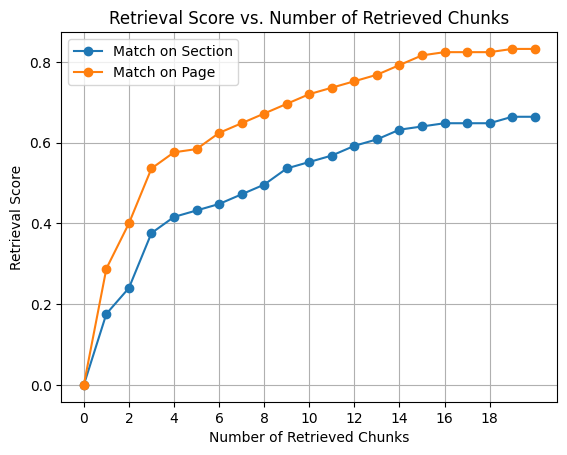

In [88]:
df_retrieval_scores = pd.DataFrame(
    {
        col_name: [
            get_retrieval_score(
                references=df_eval_dataset_with_retrieval["source"].tolist(),
                retrieved=df_eval_dataset_with_retrieval[
                    f"retrieved_sources_at_{n}"
                ].tolist(),
                exact_match=exact_match,
            )
            for n in range(max_num_chunks + 1)
        ]
        for col_name, exact_match in zip(
            ["exact_match", "not_exact_match"],
            [True, False],
        )
    }
)

ax = df_retrieval_scores["exact_match"].plot(marker="o", label="Match on Section")
df_retrieval_scores["not_exact_match"].plot(
    ax=ax,
    marker="o",
    label="Match on Page",
    title="Retrieval Score vs. Number of Retrieved Chunks",
    xlabel="Number of Retrieved Chunks",
    ylabel="Retrieval Score",
    grid=True,
    xticks=range(0, 20, 2),
)
plt.legend()

The chart indicates two interesting points:
- Retrieval improvement is not linear, there are diminishing returns as we increase n (the number of chunks).
- If we expand to the entire parent page after retrieving a chunk which is a common strategy, we can expect to get a significant improvement in retrieval quality.

### Taking it one step further

**On context relevance**:

So far our assessment of relevance was a binary decision in case the context overlaps with the context used to generate the question.

We can make the score more granular by:
- Prompting an LLM to extract relevant sentences from context given the question and either
  - Ask the LLM to provide a score on a certain scale.
  - Take the ratio of the number of extracted sentences to total number of sentences as the score.

**On other measures of retrieval quality:**

We can take a look at context attribution. In a more refined evaluation dataset where a given ground truth answer is associated with multiple contexts, we will want to measure the recall of the retrieval process.

To do so, we can:
- Prompt an LLM to attribute the context to the ground truth answer.

### External References
See the following third party references for more information on building an evaluation dataset:
- [RAGAS Context Relevance](https://github.com/explodinggradients/ragas/blob/v0.0.22/src/ragas/metrics/_context_relevancy.py#L19)
- [TrueLens Evaluation Context Relevance](https://github.com/truera/trulens/blob/trulens-eval-0.20.0/trulens_eval/trulens_eval/feedback/v2/feedback.py#L201)
- [ARES Context Relevance](https://github.com/stanford-futuredata/ARES/blob/main/RAG_Automatic_Evaluation/LLMJudge_RAG_Compared_Scoring.py#L331)
- [Llamaindex Context Relevance](https://github.com/run-llama/llama_index/blob/main/llama_index/evaluation/context_relevancy.py)

### Cost Anaylsis

Let's assess our retrieval cost so far

Retrieval cost is composed of two main components:
- Cost of encoding the query
- Cost of querying the search index


Given the following pricing information:

In [89]:
PRICING = {
    # https://docs.endpoints.anyscale.com/pricing
    "embeddings": {
        # Pricing per 1M tokens
        "thenlper/gte-large": 0.05,
    },
    # https://docs.pinecone.io/docs/understanding-cost#serverless-indexes
    "search": {
        # Pricing per 1M units
        "read_unit": 8.25,  # A fetch request uses 1 RU for every 10 fetched records.
        "write_unit": 2.00,
        # Pricing per GB per month
        "storage": 0.33,
    },
}

#### Cost of encoding the query

We first compute the query embedding cost. To do so we need to count the number of tokens in each query and multiply by the cost per token.

We implement the `count_tokens` function to count the number of tokens in a string.

In [90]:
from transformers import AutoTokenizer

def count_tokens(text, model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    return len(tokenizer.encode(text))

In [91]:
count_tokens("Hello, how are you?", EMBEDDING_MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

8

We can now produce the number of tokens for all the queries in the evaluation dataset

In [92]:
token_count = np.array([
    count_tokens(question, EMBEDDING_MODEL_NAME)
    for question in df_eval_dataset_with_retrieval["question"].tolist()
])

total_tokens = token_count.sum()
num_samples = token_count.size
print(f"Total tokens: {total_tokens} for a total of {num_samples} questions.")

Total tokens: 2215 for a total of 125 questions.


We can then compute the total embeddings cost by multiplying the total number of tokens by the cost per token.

In [93]:
embeddings_cost_per_token = PRICING["embeddings"][EMBEDDING_MODEL_NAME] / 1e6
query_encoding_costs = token_count * embeddings_cost_per_token
total_query_encoding_cost = query_encoding_costs.sum()
print(f"Query encoding cost for {num_samples} questions: {total_query_encoding_cost * 100:.3f} cents.")

Query encoding cost for 125 questions: 0.011 cents.


#### Cost of querying the search index

We then compute the search cost based on the cost per read units used.

In [94]:
read_cost_per_unit = PRICING["search"]["read_unit"] / 1e6

search_costs = {}
for n in range(max_num_chunks + 1):
    search_costs[f"search_cost_at_{n}"] = (
        read_cost_per_unit
        * df_eval_dataset_with_retrieval[f"retrieval_usage_at_{n}"]
    )

total_search_cost_for_20_chunks = search_costs["search_cost_at_20"].sum()
print(
    f"Total search cost for retrieving 20 chunks for {num_samples} questions: "
    f"{total_search_cost_for_20_chunks * 100 :.3f} cents"
)

Total search cost for retrieving 20 chunks for 125 questions: 0.722 cents


### Total Retrieval Cost

We finally put everything together to compute the total retrieval cost.

In [95]:
df_retrieval_costs_per_question = pd.DataFrame(
    {
        **{
            "encoding_cost": query_encoding_costs,
        },
        **search_costs,
    }
)
df_retrieval_costs_per_question.head()

,encoding_cost,search_cost_at_0,search_cost_at_1,search_cost_at_2,search_cost_at_3,search_cost_at_4,search_cost_at_5,search_cost_at_6,search_cost_at_7,search_cost_at_8,...,search_cost_at_11,search_cost_at_12,search_cost_at_13,search_cost_at_14,search_cost_at_15,search_cost_at_16,search_cost_at_17,search_cost_at_18,search_cost_at_19,search_cost_at_20
0,1.250000e-06,0.0,0.00005,0.00005,0.00005,0.00005,0.00005,0.00005,0.00005,0.00005,...,0.000058,0.000058,0.000058,0.000058,0.000058,0.000058,0.000058,0.000058,0.000058,0.000058
1,6.000000e-07,0.0,0.00005,0.00005,0.00005,0.00005,0.00005,0.00005,0.00005,0.00005,...,0.000058,0.000058,0.000058,0.000058,0.000058,0.000058,0.000058,0.000058,0.000058,0.000058
2,1.250000e-06,0.0,0.00005,0.00005,0.00005,0.00005,0.00005,0.00005,0.00005,0.00005,...,0.000058,0.000058,0.000058,0.000058,0.000058,0.000058,0.000058,0.000058,0.000058,0.000058
3,4.500000e-07,0.0,0.00005,0.00005,0.00005,0.00005,0.00005,0.00005,0.00005,0.00005,...,0.000058,0.000058,0.000058,0.000058,0.000058,0.000058,0.000058,0.000058,0.000058,0.000058
4,8.000000e-07,0.0,0.00005,0.00005,0.00005,0.00005,0.00005,0.00005,0.00005,0.00005,...,0.000058,0.000058,0.000058,0.000058,0.000058,0.000058,0.000058,0.000058,0.000058,0.000058


In [96]:
retrieval_cost_totals = defaultdict(list)

for n in range(max_num_chunks + 1):
    if n == 0:
        retrieval_cost_totals["encoding"].append(0)
    else:
        retrieval_cost_totals["encoding"].append(
            df_retrieval_costs_per_question["encoding_cost"].sum() * 100
        )
    retrieval_cost_totals["search"].append(
        df_retrieval_costs_per_question[f"search_cost_at_{n}"].sum() * 100
    )
    retrieval_cost_totals["retrieval"].append(
        retrieval_cost_totals["encoding"][-1] + retrieval_cost_totals["search"][-1]
    )
    retrieval_cost_totals["num_chunks"].append(n)

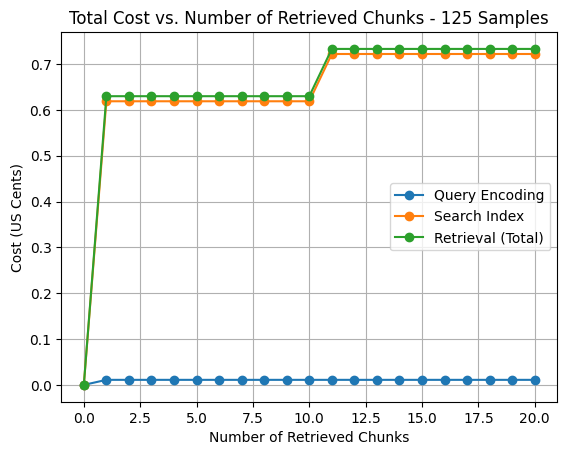

In [97]:
df_retrieval_costs = pd.DataFrame(retrieval_cost_totals)

ax = df_retrieval_costs["encoding"].plot(
    marker="o",
    label="Query Encoding",
)
df_retrieval_costs["search"].plot(marker="o", label="Search Index", ax=ax)
df_retrieval_costs["retrieval"].plot(
    marker="o",
    label="Retrieval (Total)",
    ax=ax,
    grid=True,
    title=f"Total Cost vs. Number of Retrieved Chunks - {num_samples} Samples",
    xlabel="Number of Retrieved Chunks",
    ylabel="Cost (US Cents)",
)
plt.legend()

### Assessing Trade-offs

Let's visualize the trade-offs between the retrieval score and the cost of retrieving the chunks.

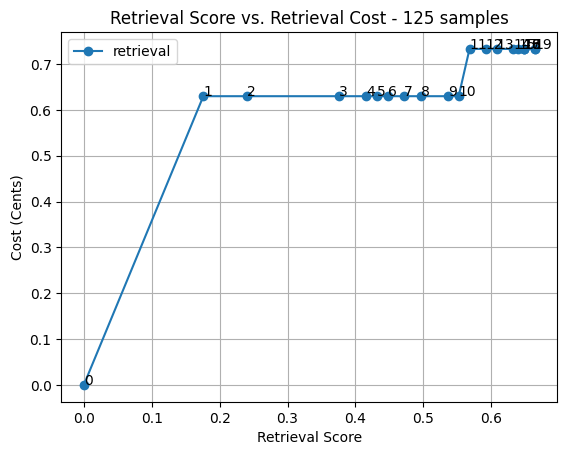

In [98]:
df_retrieval_costs_and_score = pd.merge(
    df_retrieval_costs, df_retrieval_scores, left_on="num_chunks", right_index=True
)

df_retrieval_costs_and_score.plot(
    x="exact_match",
    y="retrieval",
    marker="o",
    title=f"Retrieval Score vs. Retrieval Cost - {num_samples} samples",
    xlabel="Retrieval Score",
    ylabel="Cost (Cents)",
    grid=True,
)
for n in range(20):
    plt.text(
        df_retrieval_costs_and_score["exact_match"].iloc[n],
        df_retrieval_costs_and_score["retrieval"].iloc[n],
        str(n),
    )

Retrieving 1 document or 10 documents carries the same cost but the retrieval score is higher for 10 documents. Therefore if all we care about is retrieval score, we should retrieve 10 documents if we can afford it and it gets us to an "acceptable retrieval score".

## Evaluate Overall Quality

We will perform the overall quality evaluation in two main steps:

1. Run the generation process on the evaluation dataset to produce responses
2. Produce an overall quality score by comparing the generated responses to the ground truth answers

### 1. Run the generation process on the evaluation dataset to produce responses

We construct a `QARunner` that encapsulates the entire generation process. It performs the following steps for a list of num_chunks to try:
1. Augment the user prompt with the retrieved context
2. Generate a response to the augmented query

In [107]:
class QARunner:
    def __init__(self, model: str):
        self.llm = LLM(model=model)

    def run(self, record: dict, num_chunks_to_try: list) -> dict:
        for n in num_chunks_to_try:
            response = self.llm.generate(
                user_prompt=augment_prompt(
                    record["question"], record[f"retrieved_contexts_at_{n}"]
                )
            )
            record[f"response_at_{n}"] = response.choices[0].message.content
            record[f"usage_completion_tokens_at_{n}"] = (
                response.usage.completion_tokens
            )
            record[f"usage_prompt_tokens_at_{n}"] = (
                response.usage.prompt_tokens
            )
        return record

    __call__ = run

We will proceed to limit the dataset size so we don't wait too long for the results.

In [108]:
limit = 1

ds = (
    ray.data.read_parquet(
        DATA_DIR / "evaluation" / "reference_with_retrieval",
    )
    .limit(limit)
    .materialize()
)

Parquet Files Sample 0:   0%|          | 0/1 [00:00<?, ?it/s]

2024-03-09 15:11:29,081	INFO set_read_parallelism.py:115 -- Using autodetected parallelism=64 for operator ReadParquet to satisfy parallelism at least twice the available number of CPUs (32).
2024-03-09 15:11:29,082	INFO set_read_parallelism.py:122 -- To satisfy the requested parallelism of 64, each read task output is split into 64 smaller blocks.
2024-03-09 15:11:29,083	INFO streaming_executor.py:110 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadParquet] -> LimitOperator[limit=1]
2024-03-09 15:11:29,084	INFO streaming_executor.py:111 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=0, gpu=0, object_store_memory=0), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2024-03-09 15:11:29,084	INFO streaming_executor.py:113 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().exe

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

We choose to experiment with the following subset of number of chunks:

In [109]:
num_chunks_to_try = [0, 2, 3, 5, 10, 20]

We run the QARunner by mapping it over the dataset.

In [110]:
ds.map(
    QARunner,
    fn_constructor_kwargs={"model": "mistralai/Mixtral-8x7B-Instruct-v0.1"},
    fn_kwargs={"num_chunks_to_try": num_chunks_to_try},
    concurrency=(NUM_AVAILABLE_CPUS, NUM_AVAILABLE_CPUS),
).to_pandas()

2024-03-09 15:12:04,862	INFO streaming_executor.py:110 -- Executing DAG InputDataBuffer[Input] -> ActorPoolMapOperator[Map(QARunner)]
2024-03-09 15:12:04,862	INFO streaming_executor.py:111 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=0, gpu=0, object_store_memory=0), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2024-03-09 15:12:04,863	INFO streaming_executor.py:113 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
2024-03-09 15:12:04,904	INFO actor_pool_map_operator.py:126 -- Map(QARunner): Waiting for 7 pool actors to start...


Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

2024-03-09 15:12:33,079	WARNING actor_pool_map_operator.py:294 -- To ensure full parallelization across an actor pool of size 7, the Dataset should consist of at least 7 distinct blocks. Consider increasing the parallelism when creating the Dataset.


,question,answer,source,retrieved_sources,retrieved_contexts,retrieval_usage,retrieved_sources_at_0,retrieved_contexts_at_0,retrieval_usage_at_0,retrieved_sources_at_1,...,usage_prompt_tokens_at_3,response_at_5,usage_completion_tokens_at_5,usage_prompt_tokens_at_5,response_at_10,usage_completion_tokens_at_10,usage_prompt_tokens_at_10,response_at_20,usage_completion_tokens_at_20,usage_prompt_tokens_at_20
0,How to disconnnect ray client?,"To disconnect a ray client, you need to call t...",https://docs.ray.io/en/master/cluster/running-...,[https://docs.ray.io/en/master/cluster/running...,"[How do you use the Ray Client?#, Client disco...",7,[],[],0,[https://docs.ray.io/en/master/cluster/running...,...,403,"To disconnect a Ray client, you need to call ...",147,587,"To disconnect a Ray client, you need to call ...",262,1321,"To disconnect a Ray client, you can call the ...",260,2325


### 2. Produce an overall quality score

In [111]:
prompt_template_scoring = """
Your job is to score the quality and correctness by providing an integer score between 1 and 5 of the following suggested answer:
{generated_answer}

given the following query:
{query} 

and given the following ground truth answer:
{reference_answer}.

You must return JSON response with the following fields:
- score: the score you give to the answer
- reasoning: your reasoning for the score
You must be very strict and avoid speculation.
"""

We create an `OverallQualityEvaluator` to evaluate the quality of the generated answers.

In [112]:
class OverallQualityEvaluator:
    def __init__(self, prompt_template: str, model: str):
        self.llm = LLM(model=model)
        self.prompt_template = prompt_template

    def evaluate(
        self,
        record: dict,
        response_format: dict,
        generated_answer_key: str,
    ) -> dict:
        prompt = self.prompt_template.format(
            query=record["question"],
            generated_answer=record[generated_answer_key],
            reference_answer=record["answer"],
        )
        response = self.llm.generate(
            user_prompt=prompt, response_format=response_format, temperature=0
        )
        try:
            record.update(json.loads(response.choices[0].message.content))
        except json.JSONDecodeError:
            record["score"] = -999
            record["reasoning"] = "Invalid JSON response."
        return record

    __call__ = evaluate

We will make use of JSON mode and accordingly define the JSON schema of the intended response

In [113]:
class ScoreResponse(BaseModel):
    score: int = Field(
        ...,
        description="The score you give to the answer.",
        ge=1,
        le=5,
    )
    reasoning: str = Field(
        ...,
        description="Your reasoning for the score.",
    )

ScoreResponse.model_json_schema()

{'properties': {'score': {'description': 'The score you give to the answer.',
   'maximum': 5,
   'minimum': 1,
   'title': 'Score',
   'type': 'integer'},
  'reasoning': {'description': 'Your reasoning for the score.',
   'title': 'Reasoning',
   'type': 'string'}},
 'required': ['score', 'reasoning'],
 'title': 'ScoreResponse',
 'type': 'object'}

We run a few examples to introspect the scoring 

In [114]:
overall_quality_evaluator = OverallQualityEvaluator(
    model="mistralai/Mixtral-8x7B-Instruct-v0.1", prompt_template=prompt_template_scoring
)
overall_quality_evaluator.evaluate(
    record={
        "question": "How can I deploy Ray Serve to Kubernetes?",
        "answer": "You can deploy Ray Serve to Kubernetes using the KubeRay operator.",
        "response_at_0": "I don't know.",
    },
    generated_answer_key="response_at_0",
    response_format={
        "type": "json_object",
        "schema": ScoreResponse.model_json_schema(),
    },
)

{'question': 'How can I deploy Ray Serve to Kubernetes?',
 'answer': 'You can deploy Ray Serve to Kubernetes using the KubeRay operator.',
 'response_at_0': "I don't know.",
 'score': 1,
 'reasoning': "The suggested answer 'I don't know' is not helpful in this context and does not contribute to the discussion of deploying Ray Serve to Kubernetes."}

In [115]:
overall_quality_evaluator = OverallQualityEvaluator(
    model="mistralai/Mixtral-8x7B-Instruct-v0.1", prompt_template=prompt_template_scoring
)
overall_quality_evaluator.evaluate(
    record={
        "question": "How can I deploy Ray Serve to Kubernetes?",
        "answer": "You can deploy Ray Serve to Kubernetes using the KubeRay operator and the Service Controller.",
        "response_at_1": "Use the KubeRay operator.",
    },
    generated_answer_key="response_at_1",
    response_format={
        "type": "json_object",
        "schema": ScoreResponse.model_json_schema(),
    },
)

{'question': 'How can I deploy Ray Serve to Kubernetes?',
 'answer': 'You can deploy Ray Serve to Kubernetes using the KubeRay operator and the Service Controller.',
 'response_at_1': 'Use the KubeRay operator.',
 'score': 4,
 'reasoning': 'The suggested answer is mostly correct, as the KubeRay operator can be used to deploy Ray Serve on Kubernetes. However, it is missing the mention of the Service Controller, which is also necessary for a complete deployment. The answer could be more specific in explaining how to use the KubeRay operator to deploy Ray Serve.'}

In [116]:
overall_quality_evaluator = OverallQualityEvaluator(
    model="mistralai/Mixtral-8x7B-Instruct-v0.1", prompt_template=prompt_template_scoring
)
overall_quality_evaluator.evaluate(
    record={
        "question": "How can I deploy Ray Serve to Kubernetes?",
        "answer": "You can deploy Ray Serve to Kubernetes using the KubeRay operator and the Service Controller.",
        "response_at_5": "Use the KubeRay operator and the Service Controller.",
    },
    generated_answer_key="response_at_5",
    response_format={
        "type": "json_object",
        "schema": ScoreResponse.model_json_schema(),
    },
)

{'question': 'How can I deploy Ray Serve to Kubernetes?',
 'answer': 'You can deploy Ray Serve to Kubernetes using the KubeRay operator and the Service Controller.',
 'response_at_5': 'Use the KubeRay operator and the Service Controller.',
 'score': 5,
 'reasoning': 'The suggested answer is correct and provides detailed instructions on how to deploy Ray Serve to Kubernetes. The KubeRay operator and Service Controller are both tools provided by the Ray project to simplify the deployment of Ray applications on Kubernetes.'}

To scale up the evaluation, we can use Ray to parallelize the evaluation of the generated answers.

In [117]:
limit = 1

ds = (
    ray.data.read_parquet(DATA_DIR / "evaluation" / "reference_with_answer")
    .limit(limit)
    .materialize()
)

out = ds.map(
    OverallQualityEvaluator,
    concurrency=limit,
    fn_constructor_kwargs={
        "model": "mistralai/Mixtral-8x7B-Instruct-v0.1",
        "prompt_template": prompt_template_scoring,
    },
    fn_kwargs={
        "generated_answer_key": "response_at_20",
        "response_format": {
            "type": "json_object",
            "schema": ScoreResponse.model_json_schema(),
        },
    },
).to_pandas()

Parquet Files Sample 0:   0%|          | 0/1 [00:00<?, ?it/s]

2024-03-09 15:14:53,511	INFO set_read_parallelism.py:115 -- Using autodetected parallelism=64 for operator ReadParquet to satisfy parallelism at least twice the available number of CPUs (32).
2024-03-09 15:14:53,512	INFO set_read_parallelism.py:122 -- To satisfy the requested parallelism of 64, each read task output is split into 64 smaller blocks.
2024-03-09 15:14:53,512	INFO streaming_executor.py:110 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadParquet] -> LimitOperator[limit=1]
2024-03-09 15:14:53,513	INFO streaming_executor.py:111 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=0, gpu=0, object_store_memory=0), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2024-03-09 15:14:53,513	INFO streaming_executor.py:113 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().exe

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

2024-03-09 15:14:53,654	INFO streaming_executor.py:110 -- Executing DAG InputDataBuffer[Input] -> ActorPoolMapOperator[Map(OverallQualityEvaluator)]
2024-03-09 15:14:53,655	INFO streaming_executor.py:111 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=0, gpu=0, object_store_memory=0), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2024-03-09 15:14:53,655	INFO streaming_executor.py:113 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
2024-03-09 15:14:53,670	INFO actor_pool_map_operator.py:126 -- Map(OverallQualityEvaluator): Waiting for 1 pool actors to start...


Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

In [118]:
out.head()

,question,answer,source,retrieved_sources,retrieved_contexts,retrieval_usage,retrieved_sources_at_0,retrieved_contexts_at_0,retrieval_usage_at_0,retrieved_sources_at_1,...,response_at_5,usage_prompt_tokens_at_2,usage_prompt_tokens_at_3,usage_prompt_tokens_at_5,usage_completion_tokens_at_2,usage_completion_tokens_at_3,usage_completion_tokens_at_5,__index_level_0__,score,reasoning
0,Why would I use Ray Serve instead of Modal or ...,Ray Serve is a scalable model serving library ...,https://docs.ray.io/en/master/serve/index.html...,[https://docs.ray.io/en/master/serve/index.htm...,"[As an open-source project, Ray Serve brings t...",7,[],[],0,[https://docs.ray.io/en/master/serve/index.htm...,...,You might choose to use Ray Serve over Modal ...,423,438,593,279,225,269,0,4,The suggested answer correctly identifies Ray ...


We have went ahead and ran the above code for the entire evaluation dataset over many chunks. We will go ahead and load the file to view how the scores look like.

In [119]:
df_quality_scores_per_prompt = pd.read_parquet(
    DATA_DIR / "evaluation" / "reference_with_scores" / "data.parquet"
)
for n in num_chunks_to_try:
    df_quality_scores_per_prompt = df_quality_scores_per_prompt[
        df_quality_scores_per_prompt[f"score_at_{n}"] != -999
    ]

We plot the mean generation scores for each number of retrieved chunks.

<Axes: title={'center': 'Overall Mean Quality Score vs. Number of Retrieved Chunks'}, xlabel='Number of Retrieved Chunks', ylabel='Overall Mean Quality Score (1-5)'>

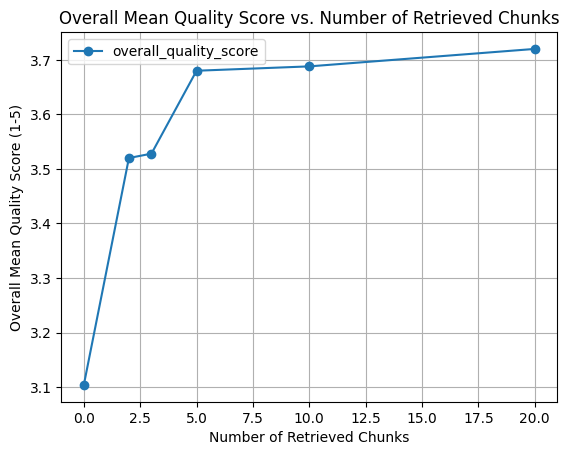

In [120]:
df_overall_quality_scores = pd.DataFrame(
    {
        "num_chunks": num_chunks_to_try,
        "overall_quality_score": [
            df_quality_scores_per_prompt[f"score_at_{num_chunks}"].mean()
            for num_chunks in num_chunks_to_try
        ],
    }
)

df_overall_quality_scores.plot(
    x="num_chunks",
    y="overall_quality_score",
    marker="o",
    grid=True,
    title="Overall Mean Quality Score vs. Number of Retrieved Chunks",
    xlabel="Number of Retrieved Chunks",
    ylabel="Overall Mean Quality Score (1-5)",
)

### Overall Cost Analysis

Next we move to analyzing the cost of the overall quality evaluation.

The total cost of the overall quality evaluation is composed of two main components:
- Cost of Retrieval
- Cost of Generation

The cost of retrieval is the same as we computed earlier.

### Generation cost

Generation cost is computed as the total cost of input tokens and output tokens. In the case of anyscale endpoints input and output tokens are priced the same.

In [121]:
# https://docs.endpoints.anyscale.com/pricing

PRICING["llms"] = {
    # Pricing per 1M tokens
    "meta-llama/Llama-2-7b-chat-hf": {"input": 0.15, "output": 0.15},
    "meta-llama/Llama-2-13b-chat-hf": {"input": 0.25, "output": 0.25},
    "meta-llama/Llama-2-70b-chat-hf": {"input": 1, "output": 1},
    "codellama/CodeLlama-70b-Instruct-hf": {"input": 1, "output": 1},
    "mistralai/Mistral-7B-Instruct-v0.1": {"input": 0.15, "output": 0.15},
    "mistralai/Mixtral-8x7B-Instruct-v0.1": {"input": 0.50, "output": 0.50},
}

In [122]:
model = "mistralai/Mixtral-8x7B-Instruct-v0.1"

We compute the total cost for generating responses given 20 retrieved chunks.

In [123]:
total_cost_at_20 = (
    df_quality_scores_per_prompt["usage_completion_tokens_at_20"]
    * PRICING["llms"][model]["output"]
    / 1e6
    + df_quality_scores_per_prompt["usage_prompt_tokens_at_20"]
    * PRICING["llms"][model]["input"]
    / 1e6
).sum()

print(
    f"Total cost at 20: {total_cost_at_20 * 100:.3f} cents for {num_samples} questions."
)

Total cost at 20: 22.075 cents for 125 questions.


In [124]:
total_cost_at_13 = (
    df_quality_scores_per_prompt["usage_completion_tokens_at_13"]
    * PRICING["llms"][model]["output"]
    / 1e6
    + df_quality_scores_per_prompt["usage_prompt_tokens_at_13"]
    * PRICING["llms"][model]["input"]
    / 1e6
).sum()

print(
    f"Total cost at 13: {total_cost_at_13 * 100:.3f} cents for {num_samples} queries."
)

Total cost at 13: 14.844 cents for 125 queries.


In [125]:
total_cost_at_10 = (
    df_quality_scores_per_prompt["usage_completion_tokens_at_10"]
    * PRICING["llms"][model]["output"]
    / 1e6
    + df_quality_scores_per_prompt["usage_prompt_tokens_at_10"]
    * PRICING["llms"][model]["input"]
    / 1e6
).sum()

print(
    f"Total cost at 10: {total_cost_at_10 * 100:.3f} cents for {num_samples} queries."
)

Total cost at 10: 11.750 cents for 125 queries.


In [126]:
total_cost_at_0 = (
    df_quality_scores_per_prompt["usage_completion_tokens_at_0"]
    * PRICING["llms"][model]["output"]
    / 1e6
    + df_quality_scores_per_prompt["usage_prompt_tokens_at_0"]
    * PRICING["llms"][model]["input"]
    / 1e6
).sum()

print(f"Total cost at 0: {total_cost_at_0 * 100:.3f} cents for {num_samples} queries.")

Total cost at 0: 1.998 cents for 125 queries.


In [127]:
gen_cost_totals = defaultdict(list)

for num_chunks in num_chunks_to_try:
    generation_cost = (
        df_quality_scores_per_prompt[f"usage_completion_tokens_at_{num_chunks}"]
        * PRICING["llms"][model]["output"]
        / 1e6
        + df_quality_scores_per_prompt[f"usage_prompt_tokens_at_{num_chunks}"]
        * PRICING["llms"][model]["input"]
        / 1e6
    ).sum() * 100

    gen_cost_totals["generation_cost"].append(generation_cost)
    gen_cost_totals["num_chunks"].append(num_chunks)

df_generation_costs = pd.DataFrame(gen_cost_totals)

### Overall cost

Now that we computed both generation and retrieval costs, we can compute the overall cost for the entire RAG pipeline.

Text(0, 0.5, 'Cost (US Cents)')

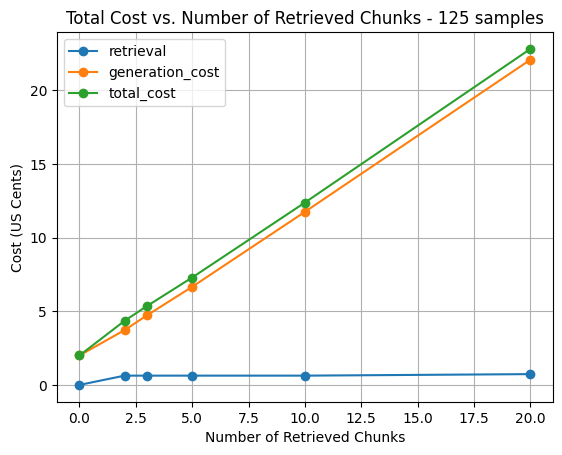

In [128]:
df_overall_costs = pd.merge(
    df_retrieval_costs,
    df_generation_costs,
    on="num_chunks",
)
df_overall_costs["total_cost"] = (
    df_overall_costs["generation_cost"] + df_overall_costs["retrieval"]
)
df_overall_costs.plot(
    x="num_chunks", y=["retrieval", "generation_cost", "total_cost"], marker="o"
)
plt.grid()
plt.title(f"Total Cost vs. Number of Retrieved Chunks - {num_samples} samples")
plt.xlabel("Number of Retrieved Chunks")
plt.ylabel("Cost (US Cents)")

As you can see above LLM generation costs dominate the overall cost. The cost of retrieval is relatively low compared to the cost of generation. 


### Assess trade-offs between score and quality

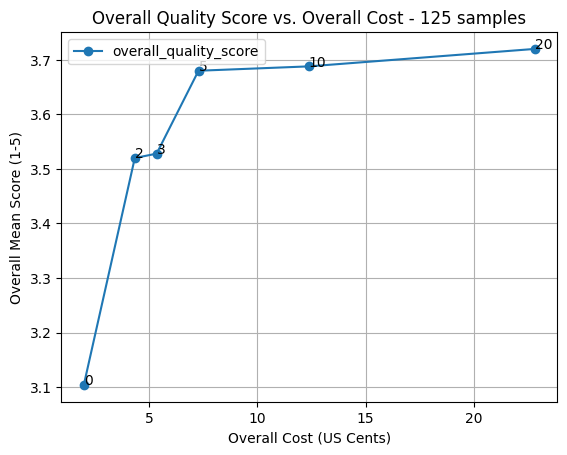

In [129]:
df_overall_score_and_cost = pd.merge(
    df_overall_quality_scores,
    df_overall_costs,
    on="num_chunks",
)

df_overall_score_and_cost.plot(
    x="total_cost",
    y="overall_quality_score",
    marker="o",
    grid=True,
    title=f"Overall Quality Score vs. Overall Cost - {num_samples} samples",
    xlabel="Overall Cost (US Cents)",
    ylabel="Overall Mean Score (1-5)",
)
for idx, num_chunks in enumerate(num_chunks_to_try):
    plt.text(
        df_overall_score_and_cost["total_cost"].iloc[idx],
        df_overall_score_and_cost["overall_quality_score"].iloc[idx],
        str(num_chunks),
    )

Based on the above chart we might want to choose `top_k=5` where the cost is relatively low and the overall quality score is relatively high.